In [348]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("""
# #################################################################################################
#  Full ANN Code Along - Regression Part One(1) - Feature Engineering
# #################################################################################################
""")


# #################################################################################################
#  Full ANN Code Along - Regression Part One(1) - Feature Engineering
# #################################################################################################



In [349]:
df = pd.read_csv('../../../notebooks/Data/NYCTaxiFares.csv')
print(df.head())
print(df['fare_amount'].describe())

           pickup_datetime  fare_amount  fare_class  pickup_longitude  \
0  2010-04-19 08:17:56 UTC          6.5           0        -73.992365   
1  2010-04-17 15:43:53 UTC          6.9           0        -73.990078   
2  2010-04-17 11:23:26 UTC         10.1           1        -73.994149   
3  2010-04-11 21:25:03 UTC          8.9           0        -73.990485   
4  2010-04-17 02:19:01 UTC         19.7           1        -73.990976   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.730521         -73.975499         40.744746                1  
1        40.740558         -73.974232         40.744114                1  
2        40.751118         -73.960064         40.766235                2  
3        40.756422         -73.971205         40.748192                1  
4        40.734202         -73.905956         40.743115                1  
count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700

In [350]:
def haversine_distance(df, src_lat, src_long, tar_lat, tar_long):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers

    phi1 = np.radians(df[src_lat])
    phi2 = np.radians(df[tar_lat])

    delta_phi = phi2 - phi1
    delta_lambda = np.radians(df[tar_long] - df[src_long])

    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = (r * c)  # in kilometers
    return d

In [351]:
# FEATURE ENGINEERING - Taking a existing features already have, create new more useful features
# than original features.

# Engineering distance between two points with co-ordinates.
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                                   'dropoff_longitude')
print(df['dist_km'].head())

print(df.info())

0    2.126312
1    1.392307
2    3.326763
3    1.864129
4    7.231321
Name: dist_km, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB
None


In [352]:
# Engineering datetime object(string) to be DateTime object.
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB
None
            pickup_datetime  fare_amount  fare_class  pickup_longitude  \
0 2010-04-19 08:17:56+00:00          6.5           0        -73.99

In [353]:
my_time = df['pickup_datetime'][0]
print(my_time)
print(my_time.hour)

2010-04-19 08:17:56+00:00
8


In [354]:
df['EDTDate'] = df['pickup_datetime'].dt.tz_convert('US/Eastern')
df['Hour'] = df['EDTDate'].dt.hour
df['AMorPM'] = np.where(df['Hour'] >= 12, 'pm', 'am')
df['Weekday'] = df['EDTDate'].dt.strftime('%a')

print(df.head())

            pickup_datetime  fare_amount  fare_class  pickup_longitude  \
0 2010-04-19 08:17:56+00:00          6.5           0        -73.992365   
1 2010-04-17 15:43:53+00:00          6.9           0        -73.990078   
2 2010-04-17 11:23:26+00:00         10.1           1        -73.994149   
3 2010-04-11 21:25:03+00:00          8.9           0        -73.990485   
4 2010-04-17 02:19:01+00:00         19.7           1        -73.990976   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.730521         -73.975499         40.744746                1   
1        40.740558         -73.974232         40.744114                1   
2        40.751118         -73.960064         40.766235                2   
3        40.756422         -73.971205         40.748192                1   
4        40.734202         -73.905956         40.743115                1   

    dist_km                   EDTDate  Hour AMorPM Weekday  
0  2.126312 2010-04-19 04:17:56-04:00

In [355]:
print("""
# #################################################################################################
#  Full ANN Code Along - Regression Part Two(2) (Categorical and Continuous Features)
# #################################################################################################
""")


# #################################################################################################
#  Full ANN Code Along - Regression Part Two(2) (Categorical and Continuous Features)
# #################################################################################################



In [356]:
categorical_cols = ['Hour', 'AMorPM', 'Weekday']
continuous_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                   'dropoff_latitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']     # Hence regression problem.

In [357]:
# Change the categorical columns's data type('dtype') to 'category' type, so neural network can understand
# assigning a number.
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [358]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [359]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [360]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype                     
---  ------             --------------   -----                     
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]       
 1   fare_amount        120000 non-null  float64                   
 2   fare_class         120000 non-null  int64                     
 3   pickup_longitude   120000 non-null  float64                   
 4   pickup_latitude    120000 non-null  float64                   
 5   dropoff_longitude  120000 non-null  float64                   
 6   dropoff_latitude   120000 non-null  float64                   
 7   passenger_count    120000 non-null  int64                     
 8   dist_km            120000 non-null  float64                   
 9   EDTDate            120000 non-null  datetime64[ns, US/Eastern]
 10  Hour               120000 non-null  category                  
 11  

In [362]:
# We can access 'category' type object details using '.cat' as in '.dt' for 'DateTime' objects.
print(df['AMorPM'].cat.categories)
print(df['AMorPM'].cat.codes)

vals = df['AMorPM'].cat.codes.values
print(type(vals))
print(vals)

Index(['am', 'pm'], dtype='object')
0         0
1         0
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8
<class 'numpy.ndarray'>
[0 0 0 ... 1 0 1]


In [363]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkd = df['Weekday'].cat.codes.values

cat = np.stack([hr, ampm, wkd], axis=1) # Join each array as a column thus, axis=1.
print(cat)

[[ 4  0  1]
 [11  0  2]
 [ 7  0  2]
 ...
 [14  1  3]
 [ 4  0  5]
 [12  1  2]]


In [364]:
# Use 'list' comprehension to derive values and stack them up to single numpy array.
cat = np.stack([df[col].cat.codes.values for col in categorical_cols], axis=1)
print(cat)

# OR skip change data type 'for loop' and embed it into the list comprehension as well.

cat = np.stack([df[col].astype('category').cat.codes.values for col in categorical_cols], axis=1)
print(cat)

[[ 4  0  1]
 [11  0  2]
 [ 7  0  2]
 ...
 [14  1  3]
 [ 4  0  5]
 [12  1  2]]
[[ 4  0  1]
 [11  0  2]
 [ 7  0  2]
 ...
 [14  1  3]
 [ 4  0  5]
 [12  1  2]]


In [365]:
# Convert numpy array to 'tensor'.
cat = torch.tensor(cat, dtype=torch.int64)
print(cat)

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])


In [366]:
# Continuous columns - Simply map them into a numpy since they are already numerical values and neurons basicaly
# understand them.

cont = np.stack([df[col].values for col in continuous_cols], axis=1)
print(cont)

# To a 'tensor'.
cont = torch.tensor(cont, dtype=torch.float)
print(cont)

[[-73.992365    40.730521   -73.975499    40.744746     1.
    2.12631159]
 [-73.990078    40.740558   -73.974232    40.744114     1.
    1.39230687]
 [-73.994149    40.751118   -73.960064    40.766235     2.
    3.32676344]
 ...
 [-73.988574    40.749772   -74.011541    40.707799     3.
    5.05252282]
 [-74.004449    40.724529   -73.992697    40.730765     1.
    1.20892296]
 [-73.955415    40.77192    -73.967623    40.763015     3.
    1.42739869]]
tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])


In [367]:
# CREATE the labels using 'fare_amount' columns, hence need to predict 'fare_amount' base on categorical and continuous
# columns values after training.
y = torch.tensor(df['fare_amount'].values, dtype=torch.float32).reshape(-1, 1)
print(y)

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])


In [368]:
# After all the data prepared.
print(cat.shape)
print(cont.shape)
print(y.shape)

torch.Size([120000, 3])
torch.Size([120000, 6])
torch.Size([120000, 1])


In [369]:
# #################################################################################################
# SET EMBEDDING Sizes
# #################################################################################################
# 1. Step - Take category sizes.
cat_szs = [len(df[col].cat.categories) for col in categorical_cols]
print(cat_szs)

# 2. Step - Take embedded sizes.
embedding_szs = [(szs, min(50, (szs + 1) // 2)) for szs in cat_szs]
print(embedding_szs)

[24, 2, 7]
[(24, 12), (2, 1), (7, 4)]


In [370]:
print("""
# ##############################################################################################################
#  Full ANN Code Along - Regression Part Three(3) (Tabular Model - Embedding, Normalization, Dropout functions)
# ##############################################################################################################
""")


# ##############################################################################################################
#  Full ANN Code Along - Regression Part Three(3) (Tabular Model - Embedding, Normalization, Dropout functions)
# ##############################################################################################################



In [371]:
# Embedding for categorical data.
cats_part = cat[:4]
print(cats_part)

self_embeds = nn.ModuleList([nn.Embedding(vocab_szs, vector_szs) for vocab_szs, vector_szs in embedding_szs])
print(self_embeds)

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])
ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)


In [372]:
# FORWARD METHOD (cats)
embeddings = []
for i, e in enumerate(self_embeds):
    embeddings.append(e(cats_part[:, i]))

print(embeddings)

[tensor([[-1.4328, -0.7196, -1.2238, -0.3575, -0.9226, -2.0296,  0.1382,  0.7235,
          0.7775, -0.3138, -2.4676,  1.1926],
        [ 0.4694,  1.2791,  0.4876, -0.2494, -0.1783, -2.7201,  1.0955,  2.4367,
          0.0406,  1.4228,  0.6940,  1.7791],
        [ 0.4361,  0.0332,  0.5071, -0.5537,  0.1664,  0.6675, -0.0738, -1.1633,
          1.2410, -0.8298, -0.8674, -0.5670],
        [ 1.1491,  1.1070,  2.2900, -2.5212,  0.1286, -0.6873,  1.2923,  0.2201,
         -0.7505, -0.4856, -0.0977,  1.5486]], grad_fn=<EmbeddingBackward>), tensor([[0.0740],
        [0.0740],
        [0.0740],
        [0.1248]], grad_fn=<EmbeddingBackward>), tensor([[ 0.4777,  0.7462,  3.0095,  2.0934],
        [ 0.2008, -0.3046, -1.4075, -0.6853],
        [ 0.2008, -0.3046, -1.4075, -0.6853],
        [-1.0269, -0.1672, -0.6329, -1.7203]], grad_fn=<EmbeddingBackward>)]


In [373]:
# Concatenate embeddings together.
z = torch.cat(embeddings, 1)
print(z)


tensor([[-1.4328, -0.7196, -1.2238, -0.3575, -0.9226, -2.0296,  0.1382,  0.7235,
          0.7775, -0.3138, -2.4676,  1.1926,  0.0740,  0.4777,  0.7462,  3.0095,
          2.0934],
        [ 0.4694,  1.2791,  0.4876, -0.2494, -0.1783, -2.7201,  1.0955,  2.4367,
          0.0406,  1.4228,  0.6940,  1.7791,  0.0740,  0.2008, -0.3046, -1.4075,
         -0.6853],
        [ 0.4361,  0.0332,  0.5071, -0.5537,  0.1664,  0.6675, -0.0738, -1.1633,
          1.2410, -0.8298, -0.8674, -0.5670,  0.0740,  0.2008, -0.3046, -1.4075,
         -0.6853],
        [ 1.1491,  1.1070,  2.2900, -2.5212,  0.1286, -0.6873,  1.2923,  0.2201,
         -0.7505, -0.4856, -0.0977,  1.5486,  0.1248, -1.0269, -0.1672, -0.6329,
         -1.7203]], grad_fn=<CatBackward>)


In [374]:
# Dropout some values from dense-vector to avoid over-fitting.
self_embed_dropout = nn.Dropout(p=0.4)
z = self_embed_dropout(z)

print(z)

tensor([[-0.0000, -0.0000, -2.0396, -0.0000, -0.0000, -3.3826,  0.2303,  1.2058,
          1.2959, -0.0000, -0.0000,  0.0000,  0.1234,  0.0000,  1.2436,  0.0000,
          3.4890],
        [ 0.0000,  2.1318,  0.8127, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
          0.0000,  2.3713,  1.1566,  0.0000,  0.1234,  0.3346, -0.0000, -0.0000,
         -1.1421],
        [ 0.0000,  0.0553,  0.8452, -0.0000,  0.0000,  0.0000, -0.1230, -1.9388,
          2.0683, -1.3830, -0.0000, -0.9450,  0.1234,  0.3346, -0.0000, -2.3459,
         -1.1421],
        [ 0.0000,  1.8451,  3.8166, -0.0000,  0.0000, -1.1454,  2.1539,  0.0000,
         -0.0000, -0.8093, -0.1629,  2.5811,  0.2080, -0.0000, -0.2787, -1.0548,
         -2.8672]], grad_fn=<MulBackward0>)


In [390]:
# Build the 'TabularModel' class.
class TabularModel(nn.Module):

    def __init__(self, embedding_size, num_continuous_f, output_size, layers, p=0.5):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(vocab_szs, vector_szs) for vocab_szs, vector_szs in embedding_size])
        self.batch_norm = nn.BatchNorm1d(num_continuous_f)
        self.dropout = nn.Dropout(p)

        num_embeds = sum([vector_szs for vocab_szs, vector_szs in embedding_size])
        input_size = num_embeds + num_continuous_f

        layer_list = []
        for l in layers:
            layer_list.append(nn.Linear(input_size, l))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(l))
            layer_list.append(nn.Dropout(p))
            input_size = l

        layer_list.append(nn.Linear(layers[-1], output_size))

        self.layer = nn.Sequential(*layer_list)

    def forward(self, x_cat, x_cont):
        _embeddings = []
        for n, emb in enumerate(self.embeddings):
            _embeddings.append(emb(x_cat[:, n]))

        x = torch.cat(_embeddings, 1)
        x = self.dropout(x)

        x_cont = self.batch_norm(x_cont)

        x = torch.cat([x, x_cont], 1)

        return self.layer(x)

In [391]:
# What does 'nn.Sequential' do.
s = nn.Sequential(nn.Linear(10, 20), nn.Linear(20, 10))
print(s)

input = torch.linspace(0, 10, 10)
output = s(input)
print(output)

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): Linear(in_features=20, out_features=10, bias=True)
)
tensor([ 0.4729,  1.4988,  0.4074,  2.4774, -1.3765, -0.8307, -2.7751, -3.5074,
         0.2735, -0.0444], grad_fn=<AddBackward0>)


In [392]:
torch.manual_seed(33)

# embed_size = [(size, min(50, (size + 1) // 2)) for size in [len(df[col].cat.categories) for col in categorical_cols]]
print(embedding_szs)

model = TabularModel(embedding_szs, cont.shape[1], 1, [200, 100], p=0.4)
print(model)


[(24, 12), (2, 1), (7, 4)]
TabularModel(
  (embeddings): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (batch_norm): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (layer): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [393]:
criterion = nn.MSELoss()    # np.sqrt(MSE) -> Root Mean Squared Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

batch_size = 60000
test_size = int(batch_size * 0.2)

# DATA SHUFFLED ALREADY.
cat_train = cat[:batch_size - test_size]
cat_test = cat[batch_size - test_size:batch_size]
cont_train = cont[:batch_size - test_size]
cont_test = cont[batch_size - test_size:batch_size]

y_train = y[:batch_size - test_size]
y_test = y[batch_size - test_size:batch_size]

print(len(cat_train))
print(len(cont_train))
print(len(y_train))
print(len(cat_test))
print(len(cont_test))
print(len(y_test))

48000
48000
48000
12000
12000
12000


In [394]:
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):

    y_pred = model.forward(cat_train, cont_train)
    # Calculate Root Mean Square Error hence dealing with price units, otherwise loss values
    # (in this case 'fare_amount') would be squared.
    loss = torch.sqrt(criterion(y_pred, y_train))  # Hence the dealing with prices.

    losses.append(loss)

    if i % 10 == 1: # Print the very first one as well.
        print(f'\repoch {i} -> loss: {loss}')

    # Back propagate.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration = time.time() - start_time # In seconds.
print(f'Training took {duration / 60} minutes')

epoch 1 -> loss: 11.779982566833496
epoch 11 -> loss: 9.593120574951172
epoch 21 -> loss: 7.657689094543457
epoch 31 -> loss: 4.390988826751709
epoch 41 -> loss: 4.146971702575684
epoch 51 -> loss: 3.578580141067505
epoch 61 -> loss: 3.4814577102661133
epoch 71 -> loss: 3.4180562496185303
epoch 81 -> loss: 3.3725616931915283
epoch 91 -> loss: 3.3421807289123535
epoch 101 -> loss: 3.3276047706604004
epoch 111 -> loss: 3.2868897914886475
epoch 121 -> loss: 3.2872910499572754
epoch 131 -> loss: 3.270890474319458
epoch 141 -> loss: 3.2557871341705322
epoch 151 -> loss: 3.2567243576049805
epoch 161 -> loss: 3.245924949645996
epoch 171 -> loss: 3.2447922229766846
epoch 181 -> loss: 3.2497453689575195
epoch 191 -> loss: 3.2212650775909424
epoch 201 -> loss: 3.2076141834259033
epoch 211 -> loss: 3.2244269847869873
epoch 221 -> loss: 3.2053728103637695
epoch 231 -> loss: 3.203829050064087
epoch 241 -> loss: 3.200155735015869
epoch 251 -> loss: 3.1930699348449707
epoch 261 -> loss: 3.19673752784

In [397]:
torch.save(model.state_dict(), 'full_ann_state.pt')

Text(0, 0.5, 'RMSE Loss')

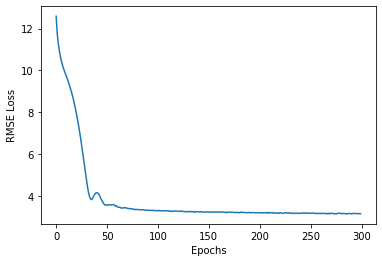

In [398]:
plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')

In [402]:
# 1. Check the loss immediate loss values.
with torch.no_grad():

    y_pred = model.forward(cat_test, cont_test)

    loss = torch.sqrt(criterion(y_pred, y_test))

    print(loss) # tensor(3.1052) - pretty much good value. No over-fitting.

# 2. Check with the entire test result set.
for i in range(10):
    diff = np.abs(y_pred[i].item() - y_test[i].item())
    print(f'{i}.) PREDICTED: {y_pred[i].item():8.2f}, ACTUAL: {y_test[i].item():8.2f}, DIFF: {diff} ')

tensor(3.0754)
0.) PREDICTED:     2.90, ACTUAL:     2.90, DIFF: 0.0009059906005859375 
1.) PREDICTED:    20.10, ACTUAL:     5.70, DIFF: 14.40075969696045 
2.) PREDICTED:     6.26, ACTUAL:     7.70, DIFF: 1.4407873153686523 
3.) PREDICTED:    13.12, ACTUAL:    12.50, DIFF: 0.6246471405029297 
4.) PREDICTED:     4.41, ACTUAL:     4.10, DIFF: 0.31119775772094727 
5.) PREDICTED:     5.30, ACTUAL:     5.30, DIFF: 0.0049896240234375 
6.) PREDICTED:     4.59, ACTUAL:     3.70, DIFF: 0.8899905681610107 
7.) PREDICTED:    16.10, ACTUAL:    14.50, DIFF: 1.6042251586914062 
8.) PREDICTED:     4.75, ACTUAL:     5.70, DIFF: 0.952178955078125 
9.) PREDICTED:     9.25, ACTUAL:    10.10, DIFF: 0.8510065078735352 
